1. First start the ipcluster using the notebook $\color{blue}{\text{start_ipcluster.ipynb}}$. Change the number if more cores are required.
2. Import the ipyparallel Client

In [1]:
from ipyparallel import Client
rc=Client(profile='mpi')

1. Start each cell with the magic command $\color{red}{\%\%px}$, else the cell won't run in parallel!!
2. Load standard modules like 'pyfftw', 'numpy', etc.
3. Load modules for current computations from the folder: $\color{red}{\text{'ClassRepository'}}$ 
4. Start the MPI communicator

In [2]:
%%px
#2.
import pyfftw as ft 
import numpy as np
from mpi4py import MPI
import math
import sys
#3.
#sys.path.insert(0,'ClassRepository')
from DataDownload import DataDownload
#from QuantitiesOfInterest import QuantitiesOfInterest
#from FourierOperations import FourierOperations
from FlowStatistics import FlowStatistics

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum
#4.
comm = MPI.COMM_WORLD
my_id = comm.Get_rank()
nproc = comm.Get_size()

if(my_id==0):
    sys.stdout.write('Starting with processors:%d\n' %(int(nproc)))

[stdout:5] Starting with processors:8


1. NxNxN is the number of grid points used in DNS computations.
2. Divide X-axis equally in all processors (nx=N/8).
3. Create objects/instances of the classes to be used later in the computations

In [3]:
%%px
#1.
N=1024
#2.
nx=N//nproc
ny=N
nz=N
#3.
myDDL=DataDownload()
#myQOI=QuantitiesOfInterest(nx,ny,nz,nproc,my_id)
#myFO=FourierOperations(nx,ny,nz,nproc,my_id)
fft = FFT3Dfield_new(nx,ny,nz,nproc,my_id)


myStats=FlowStatistics()
sys.stdout.write('MPI id:%d; divided on block size (Nx,Ny,Nz): (%d,%d,%d)\n' %(my_id,nx,ny,nz))

[stdout:0] MPI id:6; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:1] MPI id:3; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:2] MPI id:2; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:3] MPI id:5; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:4] MPI id:4; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:5] MPI id:0; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:6] MPI id:1; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:7] MPI id:7; divided on block size (Nx,Ny,Nz): (128,1024,1024)


#### Load velocity fields u, v, and w from the $\color{red}{\text{scratch}}$ folder. If the data is not available then first download the data using notebook $\color{blue}{\text{DownloadAndSaveDNSdataset.ipynb}}$

In [4]:
%%px
dirName='/home/idies/workspace/scratch/dataSnapshot/'
fileNameInitial='veldata_t1p0_myID'
comm.Barrier(); t1=MPI.Wtime()
#u,v,w=myDDL.LoadDataFromSinglefile(dirName,fileNameInitial,nproc,my_id,N)
time = 0.0
auth_token = "com.gmail.jhelsas-b854269a"
u,v,w = myDDL.DownldData_pyJHTDB('isotropic1024coarse',time,nx,ny,nz,nproc,my_id,auth_token)
#u,v,w=myDDL.LoadDataFromVM(dirName,fileNameInitial,nproc,my_id)
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Done!! Cost= %0.2f seconds\n' %(t2-t1))

[stdout:5] Done!! Cost= 272.07 seconds


In [5]:
%%px

cu = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cv = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cw = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

#### Transform velocity field from $\color{red}{\text{physical}}$ to $\color{blue}{\text{Fourier space}}$

In [6]:
%%px

#%%px
#comm.Barrier(); t1=MPI.Wtime()
#cu=myFO.GetFFT3Dfield(u)
#cv=myFO.GetFFT3Dfield(v)
#cw=myFO.GetFFT3Dfield(w)
#comm.Barrier(); t2=MPI.Wtime()
#if(my_id==0):
#    sys.stdout.write('Done!! Cost= %0.2f seconds\n' %(t2-t1))

comm.Barrier(); t1=MPI.Wtime()

cu[:,:,:] = fft.forward3Dfft(u,nx,ny,nz,nproc,my_id)
cv[:,:,:] = fft.forward3Dfft(v,nx,ny,nz,nproc,my_id)
cw[:,:,:] = fft.forward3Dfft(w,nx,ny,nz,nproc,my_id)

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] Calculate 3D spatial FFT: 72.34 seconds


#### Get the wavenumber grids

In [6]:
%%px
## IMPORTANT - not executed ant not to be executed

comm.Barrier(); t1=MPI.Wtime()
k2,kx,ky,kz=myFO.GetWavenumbers()
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Done!! Cost= %0.2f seconds\n' %(t2-t1))

[stdout:0] Done!! Cost= 9.99 seconds


In [7]:
%%px

nz_half = nz//2
myEnergySpc=EnergySpectrum()
kx,ky,kz=myEnergySpc.FindWavenumber(nx,ny,nz,my_id)
k2=np.zeros((nx,ny,nz_half+1), dtype='float32')
np.copyto(k2,kx*kx+ky*ky+kz*kz)
k2[0,0,0]=1e-6

#### Calculate radial energy in wavenumber space and plot its spectrum

In [8]:
%%px
from QuantitiesOfInterest import QuantitiesOfInterest
myQOI=QuantitiesOfInterest(nx,ny,nz,nproc,my_id)

#1.
comm.Barrier(); t1=MPI.Wtime()
ek_unfltrd=myQOI.GetEnergySpectrum(cu,cv,cw,k2)
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Done!! Cost: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] Done!! Cost: 25.97 seconds


[output:5]

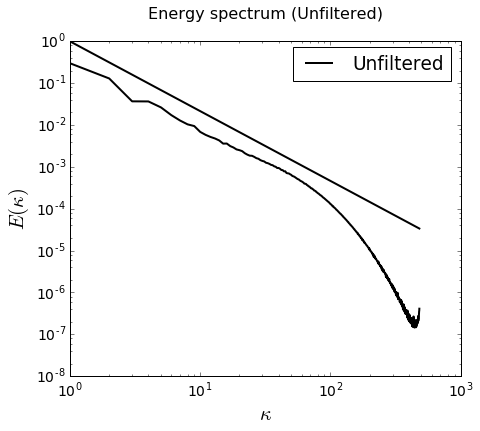

In [11]:
%%px
%matplotlib inline

nek=int(math.sqrt(2.0)/3*N)
    
import matplotlib
import matplotlib.pyplot as plt
if(my_id==0):    
    SIZE = 12
    ks=np.linspace(1,nek,nek)
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+6.5)   # legend fontsize
    plt.rc('figure', titlesize=SIZE+4)  # size of the figure title
    plt.figure(figsize=(7,6))
    symbPos=[1,4,16];lw=2;ms=10
    plt.loglog(ks,ek_unfltrd,'-k',linewidth=lw,markersize=ms,fillstyle='full',label='Unfiltered')
    plt.loglog(ks,np.power(ks,-5/3),'-k',linewidth=2)
    plt.xlabel('$\kappa$')
    plt.ylabel('$E(\kappa)$')
    plt.title('Energy spectrum (Unfiltered)\n')
    plt.axis([0.0,1000.0, 1e-8,1.0e0])
    plt.legend(loc=0,bbox_to_anchor=(1.0, 1.01),ncol=1,fancybox=False,shadow=False)
    #plt.legend(loc='outside', shadow=True) #loc='upper center'
    ax = plt.gca()
    ax.set_autoscale_on(False)

#### Get velocity gradient tensor in Physical space

In [12]:
%%px

cA11 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA12 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA13 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA21 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA22 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA23 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA31 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA32 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA33 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

In [13]:
%%px
#1.
comm.Barrier(); t1=MPI.Wtime()

#A11=myQOI.GetVelocityGradient(cu,kx)
#A12=myQOI.GetVelocityGradient(cu,ky)
#A13=myQOI.GetVelocityGradient(cu,kz)
#A21=myQOI.GetVelocityGradient(cv,kx)
#A22=myQOI.GetVelocityGradient(cv,ky)
#A23=myQOI.GetVelocityGradient(cv,kz)
#A31=myQOI.GetVelocityGradient(cw,kx)
#A32=myQOI.GetVelocityGradient(cw,ky)
#A33=myQOI.GetVelocityGradient(cw,kz)

cA11 = np.complex64(0.0+1.0j)*kx*cu
cA12 = np.complex64(0.0+1.0j)*ky*cu
cA13 = np.complex64(0.0+1.0j)*kz*cu
cA21 = np.complex64(0.0+1.0j)*kx*cv
cA22 = np.complex64(0.0+1.0j)*ky*cv
cA23 = np.complex64(0.0+1.0j)*kz*cv
cA31 = np.complex64(0.0+1.0j)*kx*cw
cA32 = np.complex64(0.0+1.0j)*ky*cw
cA33 = np.complex64(0.0+1.0j)*kz*cw

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Done!! cost= %0.2f seconds\n' %(t2-t1))

[stdout:5] Done!! cost= 20.50 seconds


In [15]:
%%px

A11 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A12 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A13 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A21 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A22 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A23 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A31 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A32 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A33 = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [17]:
%%px 

cA11[kz==(N//2)] = 0.
cA12[kz==(N//2)] = 0.
cA13[kz==(N//2)] = 0.
cA21[kz==(N//2)] = 0.
cA22[kz==(N//2)] = 0.
cA23[kz==(N//2)] = 0.
cA31[kz==(N//2)] = 0.
cA32[kz==(N//2)] = 0.
cA33[kz==(N//2)] = 0.

In [19]:
%%px

comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:

A11[:,:,:]=fft.backward3Dfft(cA11,nx,ny,nz,nproc,my_id)
A12[:,:,:]=fft.backward3Dfft(cA12,nx,ny,nz,nproc,my_id)
A13[:,:,:]=fft.backward3Dfft(cA13,nx,ny,nz,nproc,my_id)
A21[:,:,:]=fft.backward3Dfft(cA21,nx,ny,nz,nproc,my_id)
A22[:,:,:]=fft.backward3Dfft(cA22,nx,ny,nz,nproc,my_id)
A23[:,:,:]=fft.backward3Dfft(cA23,nx,ny,nz,nproc,my_id)
A31[:,:,:]=fft.backward3Dfft(cA31,nx,ny,nz,nproc,my_id)
A32[:,:,:]=fft.backward3Dfft(cA32,nx,ny,nz,nproc,my_id)
A33[:,:,:]=fft.backward3Dfft(cA33,nx,ny,nz,nproc,my_id)

#wy[:,:,:]=fft.backward3Dfft(cwy,nx,ny,nz,nproc,rank)
#wz[:,:,:]=fft.backward3Dfft(cwz,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate 3D spatial inverse FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] Calculate 3D spatial inverse FFT: 198.12 seconds


#### Reduce the sample size to avoid any memory related issue

In [24]:
%%px
#2.
Nchosen=(nx*ny*nz)//8
rng=np.random.randint(nx*ny*nz,size=Nchosen)

In [28]:
%%px

grid = np.indices((nx, ny, nz))

In [31]:
%%px

print(grid[0].shape)

[stdout:0] (128, 1024, 1024)
[stdout:1] (128, 1024, 1024)
[stdout:2] (128, 1024, 1024)
[stdout:3] (128, 1024, 1024)
[stdout:4] (128, 1024, 1024)
[stdout:5] (128, 1024, 1024)
[stdout:6] (128, 1024, 1024)
[stdout:7] (128, 1024, 1024)


In [39]:
%%px

fa11=A11.flatten()
fa12=A12.flatten()
fa13=A13.flatten()
fa21=A21.flatten()
fa22=A22.flatten()
fa23=A23.flatten()
fa31=A31.flatten()
fa32=A32.flatten()
fa33=A33.flatten()

#idx = np.random.choice(grid, 1000, replace=False)

In [40]:
%%px

a11=fa11[rng]
a12=fa12[rng]
a13=fa13[rng]
a21=fa21[rng]
a22=fa22[rng]
a23=fa23[rng]
a31=fa31[rng]
a32=fa32[rng]
a33=fa33[rng]

#### Obtain second and third invariants of velocity gradient tensor

In [41]:
%%px
comm.Barrier(); t1=MPI.Wtime()
#3.
q=myQOI.GetQ(a11,a12,a13,a21,a22,a23,a31,a32,a33)
r=myQOI.GetR(a11,a12,a13,a21,a22,a23,a31,a32,a33)
#4.
qwAvg_unfltrd=myQOI.GetQwAvg(a12,a21,a13,a31,a23,a32)
q=q/qwAvg_unfltrd
r=r/(qwAvg_unfltrd**1.5)
#5.
#topoFrac_unfltrd=myQOI.GetTopologyFraction(q,r)
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Done!! cost= %0.2f minutes\n' %(((t2-t1)/60.)))

[stdout:5] Done!! cost= 0.50 minutes


#### Get the joint probability distribution function of Q and R, and plot its well-known tear-drop shape

In [43]:
%%px
comm.Barrier(); t1=MPI.Wtime()
Ngrid=250;rmin=-25.0;rmax=25.0;qmin=-25.0;qmax=25.0 # Constants for jPDF
jPDF_unfltrd,xedges_unfltrd,yedges_unfltrd=\
myStats.FindJointPDF(r.flatten(),q.flatten(),rmin,rmax,qmin,qmax,Ngrid,Ngrid,nproc)
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Done!! cost= %0.2f minutes\n' %(((t2-t1)/60.)))

[stdout:5] Done!! cost= 0.15 minutes


This is Danish's original QR plot

[output:0]

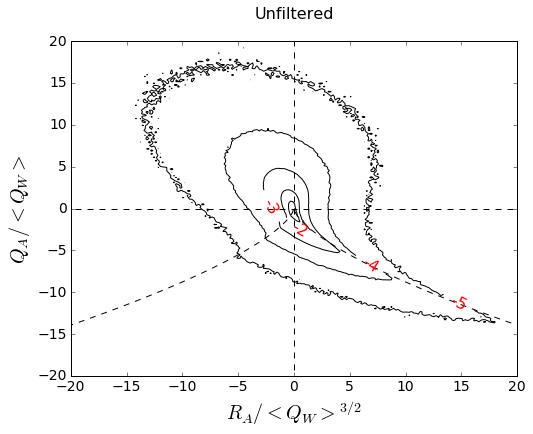

In [13]:
##%%px
## IMPORTANT - do not run this cell
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
if(my_id==0):
    fmt={}
    plt.figure()
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)  # legend fontsize
    plt.rc('figure', titlesize=SIZE+4)  # # size of the figure title
    plt.figure(figsize=(8,6))

    X,Y=np.meshgrid(xedges_unfltrd[0:Ngrid-1],yedges_unfltrd[0:Ngrid-1])

    levels=np.logspace(-5.,-1,num=5,base=10.0)#np.logspace[1e-5,1e-4,1e-3,1e-2,1e-1]
    CS=plt.contour(X,Y,jPDF_unfltrd,levels,colors='k')#[1::2] #extent=(-15,15,-15,15)
    strs=['-5','-4','-3','-2','-1']
    for l,s in zip(CS.levels,strs):
        fmt[l]=s
    plt.clabel(CS,levels,inline=True,fmt=fmt,fontsize=16,colors='r')
    #plt.colorbar()

    # lines
    Qc=np.linspace(qmin,0,50)
    Rc1=-(2./27.)*((-3.*Qc)**1.5)
    Rc2=(2./27.)*((-3.*Qc)**1.5)
    plt.plot(Rc1,Qc,'--k')
    plt.plot(Rc2,Qc,'--k')
    plt.plot([0,0],[qmin,qmax],'--k')
    plt.plot([rmin,rmax],[0,0],'--k')
    plt.axis([-20,20,-20,20])#rmin,rmax,qmin,qmax
    plt.xlabel('$R_A/<Q_W>^{3/2}$')#/\langle Q_W\rangle^{3/2}
    plt.ylabel('$Q_A/<Q_W>$')#/\langle Q_W\rangle
    plt.title('Unfiltered\n')
    plt.show()

This is my QR plot

[output:5]

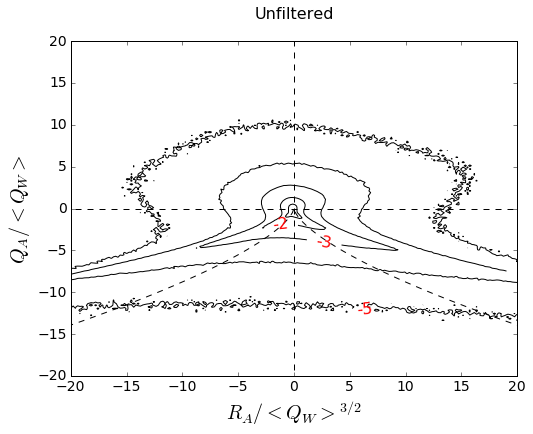

In [44]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
if(my_id==0):
    fmt={}
    plt.figure()
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)  # legend fontsize
    plt.rc('figure', titlesize=SIZE+4)  # # size of the figure title
    plt.figure(figsize=(8,6))

    X,Y=np.meshgrid(xedges_unfltrd[0:Ngrid-1],yedges_unfltrd[0:Ngrid-1])

    levels=np.logspace(-5.,-1,num=5,base=10.0)#np.logspace[1e-5,1e-4,1e-3,1e-2,1e-1]
    CS=plt.contour(X,Y,jPDF_unfltrd,levels,colors='k')#[1::2] #extent=(-15,15,-15,15)
    strs=['-5','-4','-3','-2','-1']
    for l,s in zip(CS.levels,strs):
        fmt[l]=s
    plt.clabel(CS,levels,inline=True,fmt=fmt,fontsize=16,colors='r')
    #plt.colorbar()

    # lines
    Qc=np.linspace(qmin,0,50)
    Rc1=-(2./27.)*((-3.*Qc)**1.5)
    Rc2=(2./27.)*((-3.*Qc)**1.5)
    plt.plot(Rc1,Qc,'--k')
    plt.plot(Rc2,Qc,'--k')
    plt.plot([0,0],[qmin,qmax],'--k')
    plt.plot([rmin,rmax],[0,0],'--k')
    plt.axis([-20,20,-20,20])#rmin,rmax,qmin,qmax
    plt.xlabel('$R_A/<Q_W>^{3/2}$')#/\langle Q_W\rangle^{3/2}
    plt.ylabel('$Q_A/<Q_W>$')#/\langle Q_W\rangle
    plt.title('Unfiltered\n')
    plt.show()